# Basic usage of excitingtools
**by <span style="color:darkgreen">Fabian Peschel</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](http://exciting.wikidot.com/neon)**

<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial you will learn how to use the **`excitingtools`** Python library. This library allows you to interact with the **`exciting`** framework directly from Python. Prior basic knowledge of Python is essential for understanding. Unlike most other tutorials, this one explicitly makes more intensive use of Python in its code cells. While not mandatory, you should work through some other tutorials to grasp the input-output structure of **`exciting`** and how to use it in the terminal. 

In this tutorial we will use **`excitingtools`** to define an input file, start a calculation, and evaluate the results. These three steps are usually referred to as the workflow step. A workflow, for example the convergenc of a parameter in a DFT calculation, consist of multiple workflow steps.

The capabilities of **`excitingtools`** make it possible to significantly reduce the dependence on the terminal. However, this tool was developed to be able to define larger workflows that require the automated definition of many individual calculations.

**<span style="color:firebrick">Disclaimer</span>**: The input files and **`exciting`** calculations shown in this tutorial are only intended to illustrate the various options available through the use of **`excitingtools`**. These examples may lack physical significance and are not converged. In addition, they often use hidden default settings that you want to change for your own calculations.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**

[0. General Preparation](#0)

[1. Defining input from scratch](#1)

[2. Executing `exciting` and parsing output](#2)

[3. How to use ASE atoms for input generation](#3)

[4. How to use an old input file for input generation](#4)

[5. The first workflow: A loop](#5)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. General Preparation</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

As a first step, you may set the **exciting_root** directory and create a running directory for the notebook.

In [1]:
from pathlib import Path
from excitingjupyter.utilities import get_exciting_root, check_for_binary

exciting_root = get_exciting_root()
check_for_binary(exciting_root)
species_path = (Path(exciting_root) / "species").as_posix()
path_to_binary = (Path(exciting_root) / "bin/exciting_smp").as_posix()

print(exciting_root)

/Users/fabianpeschel/code/development/exciting


In [2]:
tutorial_top_dir = Path("excitingtools_tutorial")
tutorial_top_dir.mkdir(exist_ok=True)

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Defining input from scratch</span>

Let's assume we want to perform a ground-state calculation. Using the Python API, it is possible to define the <code><span style="color:green">structure</span></code> and the <code><span style="color:green">groundstate</span></code> element without having to understand the XML structure of the input file.

In [3]:
from excitingtools import ExcitingStructure, ExcitingGroundStateInput, ExcitingInputXML

First, we focus on the definition of the physical structure, which will result in the xml <code><span style="color:green">structure</span></code> element. This involves specifying three lattice vectors and the atoms contained in the unit cell, as well as any additional structural parameters.

In [4]:
# three lattice vectors as list, in this example a simple cubic crystal
lattice = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

# atoms inside the unit cell: every atom own dictionary with species name 
# and position (fractional coordinates per default)
atoms = [{'species': 'Li', 'position': [0, 0, 0]},
         {'species': 'F', 'position': [0.5, 0.5, 0.5]}]

# structure object: pass atoms, lattice, species_path and optional properties
structure = ExcitingStructure(atoms, lattice, species_path,
                              autormt=False, epslat=1e-6,
                              crystal_properties={'scale': 3.808},
                              species_properties={'Li': {'rmt': 1.1, 
                                                         'LDAplusU': {'J': 2, 'U': 3, 'l': 1}}})

We can then proceed with the definition of the <code><span style="color:green">groundstate</span></code> element. To construct the optional subtrees, we can use nested dictionaries.

In [5]:
# groundstate object with groundstate attributes
groundstate = ExcitingGroundStateInput(ngridk=[4, 4, 4], rgkmax=4.0, gmaxvr=16, nempty=5, do='fromscratch',
                                       xctype='GGA_PBE_SOL', epschg=1e-4, epsengy=1e-4, epspot=1e-4,
                                       spin={"spinorb": False})

In these definitions we can include all supported attributes offered by **`exciting`**. During initialization, a validation check is performed to ensure that only valid keywords are used that match the **`exciting`** schema. The complete list of valid attributes can be found on the web page: **http://exciting.wikidot.com/ref:input**. If unrecognized keywords are detected, a `ValueError` is raised indicating the incorrect keywords in the error message. Similar to the standard input file, case sensitivity is crucial and must be respected.

**<span style="color:firebrick">Note</span>**: that no checks for the validity of *attribute values* are performed within **`excitingtools`**. All validity checks are performed internally within **`exciting`** itself.

As can be seen in the following example, "abc" is not valid as a keyword and "RGkmaX" is rejected because of the incorrect spelling.

In [6]:
try:
    ExcitingGroundStateInput(ngridk=[4, 4, 4], abc=1, RGkmaX=3)
except ValueError as ve:
    print(ve)

groundstate keys are not valid: {'abc', 'RGkmaX'}


Now, we can combine all components to define a complete **`exciting`** input. Mandatory are the <code><span style="color:green">structure</span></code> element, the <code><span style="color:green">groundstate</span></code> element, as well as a <code><span style="color:green">title</span></code>. The <code><span style="color:green">title</span></code> is provided as a string.

In [7]:
input_xml = ExcitingInputXML(structure=structure, groundstate=groundstate, title="Ground-state calculation")

After the creation of the Python object one can export this information to a file in XML format.
The conventional name of this file is `input.xml`. The file can then be read by the **`exciting`** software.

To accomplish this, you can simply invoke the `write()` method of the input object. Optionally, a filename can be provided as an argument. If no filename is specified a file named `input.xml` will be created in the current directory.

In [8]:
groundstate_dir = tutorial_top_dir / "groundState"
groundstate_dir.mkdir(exist_ok=True)
input_file = groundstate_dir / "input.xml"
input_xml.write(input_file)

After the XML file is generated, there is the option to manually check the contents, ensuring that the data has been properly converted to XML format. Here we use Python directly to display the content:

In [9]:
print(input_file.read_text())

<?xml version="1.0" ?>
<input>
	<title>Ground-state calculation</title>
	<structure
	   speciespath="/Users/fabianpeschel/code/development/exciting/species"
	   autormt="false"
	   epslat="1e-06">
		<crystal scale="3.808">
			<basevect>1.0 0.0 0.0</basevect>
			<basevect>0.0 1.0 0.0</basevect>
			<basevect>0.0 0.0 1.0</basevect>
		</crystal>
		<species speciesfile="F.xml">
			<atom coord="0.5 0.5 0.5"> </atom>
		</species>
		<species rmt="1.1" speciesfile="Li.xml">
			<LDAplusU
			   J="2"
			   U="3"
			   l="1">
			</LDAplusU>
			<atom coord="0 0 0"> </atom>
		</species>
	</structure>
	<groundstate
	   ngridk="4 4 4"
	   rgkmax="4.0"
	   gmaxvr="16"
	   nempty="5"
	   do="fromscratch"
	   xctype="GGA_PBE_SOL"
	   epschg="0.0001"
	   epsengy="0.0001"
	   epspot="0.0001">
		<spin spinorb="false"> </spin>
	</groundstate>
</input>



<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Executing exciting and parsing output</span>

To execute the **`exciting`** binary within Python and overcome certain limitations, the `BinaryRunner` class is used. This class enables the execution of any binary, such as the **`exciting`** binary, from within Python. It requires several parameters, including the path to the binary (including the binary's name), a run command, the number of OpenMP (OMP) threads, a maximum time limit in seconds and an optional directory to run the binary in.

**<span style="color:firebrick">Note</span>**:

 - An empty run command (i. e. `""`) is used for serial or OMP execution.
 - If you wish to use MPI, you have to use a run command like `"mpirun -np 4"`.
 - The `BinaryRunner` class allows capturing error messages that are printed to the terminal. This is necessary for automatic error handling.

In [10]:
from excitingtools.runner.runner import BinaryRunner

runner1 = BinaryRunner(path_to_binary, run_cmd="", omp_num_threads=4, time_out=500, 
                       directory=groundstate_dir.as_posix())

To run the binary and check the results, the `run()` method is used. This method returns an object containing the output and error messages. This allows looking at any messages that would have been printed to the terminal and determine the run success from them.

In [11]:
run_results = runner1.run()
vars(run_results)

{'stdout': b'',
 'stderr': b'',
 'return_code': 0,
 'success': True,
 'process_time': 15.649731874465942}

After the execution of **`exciting`** using the `BinaryRunner` class, inspection of the run directory is possible. This verifies that all output files have been generated successfully.

In [12]:
sorted(list(x.name for x in groundstate_dir.iterdir()))

['BONDLENGTH.OUT',
 'EFERMI.OUT',
 'EIGVAL.OUT',
 'EQATOMS.OUT',
 'EVALCORE.OUT',
 'EVALFV.OUT',
 'EVALSV.OUT',
 'EVECFV.OUT',
 'EVECSV.OUT',
 'F_ini.xml',
 'F_scf.xml',
 'INFO.OUT',
 'KPOINTS.OUT',
 'LATTICE.OUT',
 'LINENGY.OUT',
 'Li_ini.xml',
 'Li_scf.xml',
 'MOMENT.OUT',
 'OCCSV.OUT',
 'RMSDVEFF.OUT',
 'STATE.OUT',
 'SYMCRYS.OUT',
 'SYMGENR.OUT',
 'SYMINV.OUT',
 'SYMLAT.OUT',
 'SYMMULT.OUT',
 'SYMSITE.OUT',
 'SYMT2.OUT',
 'TOTENERGY.OUT',
 'atoms.xml',
 'eigval.xml',
 'evalcore.xml',
 'geometry.xml',
 'info.xml',
 'input.xml']

Now we will look at the output files of **`exciting`**.

To extract data from output files generated by **`exciting`**, you can utilize the parsers provided by the **`excitingtools`** library. These parsers offer a common API and allow to retrieve information from specific output files. For instance, let's consider the eigenvalues stored in the `eigval.xml` file. By using the corresponding parser, you can obtain a dictionary that contains all the relevant information from the file. Navigation through this dictionary is possible, using standard Python indexing (`[]`) to extract the desired data.

In [13]:
from excitingtools import parser_chooser

eigval_dict = parser_chooser((groundstate_dir / "eigval.xml").as_posix())
eigval_dict

{'kpt': {'1': {'ik': 1,
   'vkl': '0.000000000000e0 0.000000000000e0 0.000000000000e0',
   'state': {'1': {'ist': 1, 'eigenvalue': -1.309740537792, 'occupancy': 1.0},
    '2': {'ist': 2, 'eigenvalue': -0.627684436542, 'occupancy': 1.0},
    '3': {'ist': 3, 'eigenvalue': 0.2355068635954, 'occupancy': 1.0},
    '4': {'ist': 4, 'eigenvalue': 0.2355068635954, 'occupancy': 1.0},
    '5': {'ist': 5, 'eigenvalue': 0.2355068635954, 'occupancy': 1.0},
    '6': {'ist': 6, 'eigenvalue': 0.9280823365065, 'occupancy': 0.0},
    '7': {'ist': 7, 'eigenvalue': 1.129409101746, 'occupancy': 0.0},
    '8': {'ist': 8, 'eigenvalue': 1.129409101746, 'occupancy': 0.0},
    '9': {'ist': 9, 'eigenvalue': 1.432119587291, 'occupancy': 0.0},
    '10': {'ist': 10, 'eigenvalue': 1.432119587291, 'occupancy': 0.0},
    '11': {'ist': 11, 'eigenvalue': 1.432119587291, 'occupancy': 0.0},
    '12': {'ist': 12, 'eigenvalue': -1.309740537792, 'occupancy': 1.0},
    '13': {'ist': 13, 'eigenvalue': -0.627684436542, 'occupanc

In [14]:
eigval_dict["kpt"]["1"]["state"]["2"]["eigenvalue"]

-0.627684436542

**<span style="color:firebrick">Exercise</span>**: Try to parse the file `evalcore.xml` to get information about the core states and core state energies.

**<span style="color:firebrick">Exercise</span>**: Change the number of k-points used in the ground-state calculation and check if this actually changes the parsed result(s).

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. How to use ASE atoms for input generation</span>

The atoms object from ASE can be directly employed for <code><span style="color:green">structure</span></code> definition. Here, the utilization of the `bulk()` function is demonstrated to generate a silicon crystal. This can be converted to an `ExcitingStructure` object and inserted into the full input class. To present the outcome, the final XML string is displayed (which would normally be written to the input file).

**<span style="color:firebrick">Note</span>**: As illustrated in this example, the <code><span style="color:green">groundstate</span></code> can be specified as a dictionary. Both options, utilizing a dictionary or the corresponding Python class, are equally valid to define any input.

In [15]:
from ase.build import bulk

si_ase_atoms = bulk("Si")

exciting_si = ExcitingStructure(si_ase_atoms)

print(ExcitingInputXML(structure=exciting_si, groundstate={"ngridk": [4, 4, 4]}, title="Use ASE").to_xml_str())

<?xml version="1.0" ?>
<input>
	<title>Use ASE</title>
	<structure speciespath="./">
		<crystal>
			<basevect>0.0 5.130606428358965 5.130606428358965</basevect>
			<basevect>5.130606428358965 0.0 5.130606428358965</basevect>
			<basevect>5.130606428358965 5.130606428358965 0.0</basevect>
		</crystal>
		<species speciesfile="Si.xml">
			<atom coord="0.0 0.0 0.0"> </atom>
			<atom coord="0.25 0.25 0.25"> </atom>
		</species>
	</structure>
	<groundstate ngridk="4 4 4"> </groundstate>
</input>



<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. How to use an old input file for input generation</span>

In this section, our goal is to reuse a previously created input file. It is very likely that you have used **`exciting`** without the assistance of **`excitingtools`** in the past. Now, you may find yourself in a situation where you wish to utilize this existing file and make only minor modifications. This can be achieved by leveraging the parsing capability of the `ExcitingInputXML` class. To accomplish this, invoke the `from_xml()` method and specify the path to the original file.

In this tutorial, we will demonstrate the parsing process using the input file defined in the initial section of this tutorial:

In [16]:
new_input_xml = ExcitingInputXML.from_xml(input_file)

As an example, we can proceed modifying a few attributes and their corresponding values for educational purposes.

Firstly, we set a new <code><span style="color:green">title</span></code> by utilizing the `set_title()` method.

Further adjustments can be made within the <code><span style="color:green">structure</span></code> section. Here it is possible to modify the <code><span style="color:green">structure</span></code> attributes or the muffin-tin radius for a particular species.

In the <code><span style="color:green">groundstate</span></code> section access to various attributes follows the hierarchical order observed in the XML file. In the provided example below, a new value is assigned to `ngridk`, while `spinorb` is set to `True`. Additionally, the value of `nempty` is increased by `1`, directly using the previously specified value. Notice that this last step will fail if no value was specified before.

Moreover, defining new attributes, such as `lmaxapw`, is possible. Finally, attributes can be removed utilizing the `del` operator. In such cases, the default values defined within **`exciting`** will be utilized during execution, as for all attributes not explicitly specified.

Subsequently, we can check the resulting modifications by printing the XML string representation of the input file.

In [17]:
new_input_xml.set_title("Few modifications")

new_input_xml.structure.structure_attributes["epslat"] = 1e-5
new_input_xml.structure.species_properties["F"].rmt = 1.5

new_input_xml.groundstate.ngridk = [3, 3, 3]
new_input_xml.groundstate.spin.spinorb = True
new_input_xml.groundstate.nempty += 1

new_input_xml.groundstate.lmaxapw = 8
del new_input_xml.groundstate.epschg

print(new_input_xml.to_xml_str())

<?xml version="1.0" ?>
<input>
	<title>Few modifications</title>
	<structure
	   speciespath="/Users/fabianpeschel/code/development/exciting/species"
	   autormt="false"
	   epslat="1e-05">
		<crystal scale="3.808">
			<basevect>1.0 0.0 0.0</basevect>
			<basevect>0.0 1.0 0.0</basevect>
			<basevect>0.0 0.0 1.0</basevect>
		</crystal>
		<species speciesfile="F.xml" rmt="1.5">
			<atom coord="0.5 0.5 0.5"> </atom>
		</species>
		<species rmt="1.1" speciesfile="Li.xml">
			<LDAplusU
			   J="2"
			   U="3"
			   l="1">
			</LDAplusU>
			<atom coord="0 0 0"> </atom>
		</species>
	</structure>
	<groundstate
	   ngridk="3 3 3"
	   rgkmax="4.0"
	   gmaxvr="16"
	   nempty="6"
	   do="fromscratch"
	   xctype="GGA_PBE_SOL"
	   epsengy="0.0001"
	   epspot="0.0001"
	   lmaxapw="8">
		<spin spinorb="true"> </spin>
	</groundstate>
</input>



<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. The first workflow: A loop</span>

Up to this point, the tasks accomplished could have been performed with comparable effort directly within the terminal. However, we can use **`excitingtools`** to define workflows that are no longer manageable in the terminal.

An example is the utilization of a loop. Considering a scenario where one desires testing various values for a specific parameter while keeping all other variables fixed. To initiate this process, we establish a directory to store our calculations. Then continue employing the input file defined at the beginning of this tutorial.

In [18]:
test_dir = tutorial_top_dir / "test_dir"
test_dir.mkdir(exist_ok=True)

input_xml = ExcitingInputXML.from_xml(input_file)

Only for educational purposes and to keep the runtime reasonably low, the convergence thresholds are significantly decreased. Never do this in your real calculations!

In [19]:
input_xml.groundstate.epschg = 0.1
input_xml.groundstate.epsengy = 0.1
input_xml.groundstate.epspot = 0.1

Now it's about to establish the iterative loop, where we will vary the value of `rgkmax`. The loop will start at the value 3 and increment until reaching 7 in steps of 0.5. 

During each iteration, the following procedure will be executed:
 - A small print statement is displayed, providing the current iteration for visibility.
 - The run directory is defined and created, ensuring that existing files are not overwritten.
 - The <code><span style="color:green">title</span></code> of the calculation is modified.
 - The specific value of `rgkmax` for the current iteration is set.
 - The updated input file is written.
 - The single calculation is executed, taking into account the appropriate run directory.
 - Finally, the result of the calculation, here only the total energy, is parsed and added to the results.

In [20]:
import numpy as np

rgkmax_values = np.arange(3, 7.5, 0.5)
total_energy = []
for i in rgkmax_values:
    print(f"Now rgkmax = {i} ...")
    run_dir = test_dir / str(i)
    run_dir.mkdir(exist_ok=True)
    input_xml.set_title(f"Test Case {i}")
    input_xml.groundstate.rgkmax = i
    
    input_xml.write(run_dir / "input.xml")
    runner1.directory = run_dir
    run_results = runner1.run()
    
    total_energy.append(np.genfromtxt(run_dir / "TOTENERGY.OUT")[-1])

Now rgkmax = 3.0 ...
Now rgkmax = 3.5 ...
Now rgkmax = 4.0 ...
Now rgkmax = 4.5 ...
Now rgkmax = 5.0 ...
Now rgkmax = 5.5 ...
Now rgkmax = 6.0 ...
Now rgkmax = 6.5 ...
Now rgkmax = 7.0 ...


Visualization of the obtained results can be achieved employing common data visualization tools such as `matplotlib`.

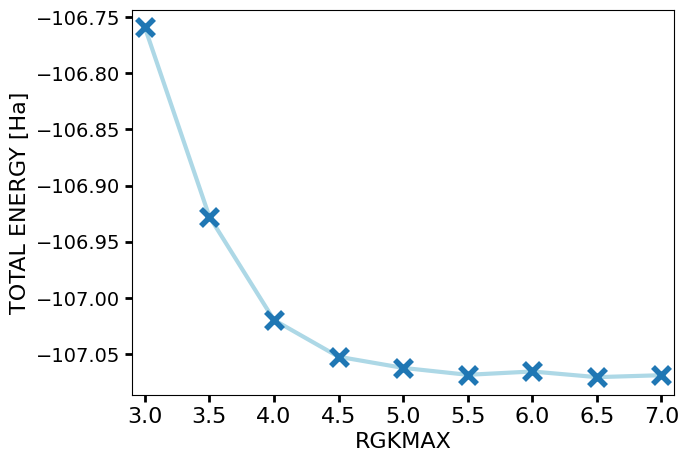

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.ylabel("TOTAL ENERGY [Ha]", fontsize=16)
plt.xlabel("RGKMAX", fontsize=16)
plt.xlim([2.9, 7.1])

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

plt.rcParams["axes.linewidth"] = 2

plt.scatter(rgkmax_values, total_energy, s=150, marker="x", linewidths=4)
plt.plot(rgkmax_values, total_energy, linewidth=3, c="lightblue", zorder=-1)

plt.show()

**<span style="color:firebrick">Summary</span>**: With the assistance of **`excitingtools`**, we made a convergence analysis with alternating values for `rgkmax`. This is generally also possible for other parameters. Here the usage of **`excitingtools`** helps to prevent errors in advance, since there is no need to change input files manually. As a result, the productivity is enhanced by a significant margin, while the likelihood of errors is reduced.

This procedure helps you in exploring and testing suitable parameter values for your seeked calculations. **`excitingtools`** makes it possible to define workflows and automatise your calculations. 

**<span style="color:firebrick">Exercise</span>**: Perform a new convergence study on `rgkmax`. This time use a different value for `nempty`. Additionally, consider performing a convergence analysis on the values of `ngridk`.

<hr style="border:2px solid #DDD"> </hr>